In [6]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Low Volume NAICS performance
Look at the model performance vs. # of businesses per NAICS.  Examine NAICS codes present in the training and test data only.  Bucket NAICS by volume, and look at test dataset performance for businesses corresponding to the buckets. 

*This script takes about 5 minutes on my MacBook Air*

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from pathlib import Path

In [9]:
from sba_gnn.sba_gnn import sg_plot 

In [256]:
sg_plot.plot_defaults()

## Input Data

In [10]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [11]:
train_df = sba_loans[sba_loans['dset'] == 'train']
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

## NAICS volume and selection
Find NAICS in the training data and get # of associated businesses.  

In [453]:
naics_train_info = sba_loans[sba_loans['dset'] == 'train'][['NAICS']].value_counts().reset_index()

In [454]:
naics_train_info['count'].sum()

425594

In [455]:
naics_train_info['count_grp'] = pd.cut(naics_train_info['count'], [1, 50, 500, np.Inf],
                                           include_lowest=True)

In [456]:
naics_train_info

,NAICS,count,count_grp
0,722110,18218,"(500.0, inf]"
1,722211,12712,"(500.0, inf]"
2,811111,9264,"(500.0, inf]"
3,621210,8997,"(500.0, inf]"
4,624410,6432,"(500.0, inf]"
...,...,...,...
1227,333241,1,"(0.999, 50.0]"
1228,333249,1,"(0.999, 50.0]"
1229,333318,1,"(0.999, 50.0]"
1230,551114,1,"(0.999, 50.0]"


In [457]:
naics_train_info.groupby('count_grp')['count'].agg(['min', 'max', 'mean', 'count', 'sum'])

,min,max,mean,count,sum
count_grp,,,,,
"(0.999, 50.0]",1,50,18.422594,478,8806
"(50.0, 500.0]",51,486,174.461672,574,100141
"(500.0, inf]",501,18218,1759.150000,180,316647


##### Codes also in test

In [458]:
naics_train_info = naics_train_info.merge(sba_loans[sba_loans['dset'] == 'test'][['NAICS']].drop_duplicates(),
                                          on='NAICS')

In [459]:
naics_train_info.groupby('count_grp')['count'].agg(['min', 'max', 'mean', 'count', 'sum'])

,min,max,mean,count,sum
count_grp,,,,,
"(0.999, 50.0]",1,50,21.299252,401,8541
"(50.0, 500.0]",51,486,174.461672,574,100141
"(500.0, inf]",501,18218,1759.150000,180,316647


## Performance by code

##### Function to take in a predictions file and get all metrics

In [460]:
def pred_metrics(filename, 
                 naics_map = sba_loans[['NAICS', 'LoanNr_ChkDgt']],
                naics_counts = naics_train_info[['NAICS', 'count_grp']]):
    """ Open file, merge NAICS counts, and get metrics by NAICS count"""
    pred_df = pd.read_parquet(filename) \
        [['LoanNr_ChkDgt', 'predict_prob', 'predict_bin', 'target', 'dset']]
    
    pred_sel = pred_df[pred_df['dset'] == 'test'] \
        .merge(naics_map[['NAICS', 'LoanNr_ChkDgt']], on='LoanNr_ChkDgt') \
        .merge(naics_counts[['NAICS', 'count_grp']], on='NAICS')

    return pred_sel.groupby('count_grp') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()

##### Apply function to many models
Summarize by count group

In [461]:
model_dict = {'xgb baseline': Path(setup.temp_path).joinpath('03_DATA_combined_predictions.parquet'),
              'xgb mean encoding':  Path(setup.temp_path).joinpath('04_DATA_combined_predictions.parquet'),
              'xgb one hot':  Path(setup.temp_path).joinpath('05_DATA_combined_predictions.parquet'),
              'xgb numeric NAICS':  Path(setup.temp_path).joinpath('06_DATA_combined_predictions.parquet'),
              'nn baseline': Path(setup.temp_path).joinpath('11_DATA_predictions.parquet'),
              'nn embed NAICS': Path(setup.temp_path).joinpath('12_DATA_predictions.parquet'),
              'gnn': Path(setup.temp_path).joinpath('24_DATA_predictions_all.parquet'),
              'xgb + nn embed': Path(setup.temp_path).joinpath('50_DATA_combined_predictions.parquet'),
              'xgb + dgi embed': Path(setup.temp_path).joinpath('51_DATA_combined_predictions.parquet'),
              'xgb + dgi embed, label': Path(setup.temp_path).joinpath('52_DATA_combined_predictions.parquet')}

In [462]:
metrics_comb = pd.concat([pred_metrics(v) for k, v in model_dict.items()],
                         keys = model_dict.keys()) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'model'})

In [463]:
metrics_comb.to_csv(Path(setup.temp_path).joinpath('55_REPORT_metrics_naics_low_volume.csv'),
                    index=False)

In [464]:
metrics_comb.head(3)

,model,count_grp,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
0,xgb baseline,"(0.999, 50.0]",0.687909,0.446166,0.324690,0.712871,0.377538,0.759512
1,xgb baseline,"(50.0, 500.0]",0.628234,0.429700,0.306472,0.718664,0.350704,0.717602
2,xgb baseline,"(500.0, inf]",0.601029,0.431523,0.306237,0.730297,0.352295,0.700597


## Plot selected metrics

In [465]:
overall_perf = 0.44

In [466]:
sg_plot.plot_defaults()
#plt.style.use('fast')

In [467]:
#model_list = ['xgb baseline', 'nn baseline', 'nn embed NAICS', 'gnn']
model_list = ['xgb baseline', 'xgb mean encoding', 'xgb numeric NAICS', 'nn baseline', 'nn embed NAICS',
             'xgb + nn embed', 'xgb + dgi embed', 'xgb + dgi embed, label']

In [468]:
metric = 'f1_score'

In [476]:
#[metrics_comb['model'].isin(model_list)] \
plot_df = metrics_comb \
    [['count_grp', metric, 'model']] \
    .pivot(index='count_grp', columns='model', values=metric)

In [477]:
#plot_df = plot_df.apply(lambda x: x-plot_df['xgb baseline'], axis=0)

In [478]:
plot_df['xgb baseline']

count_grp
(0.999, 50.0]    0.446166
(50.0, 500.0]    0.429700
(500.0, inf]     0.431523
Name: xgb baseline, dtype: float64

In [479]:
plot_df

model,gnn,nn baseline,nn embed NAICS,xgb + dgi embed,"xgb + dgi embed, label",xgb + nn embed,xgb baseline,xgb mean encoding,xgb numeric NAICS,xgb one hot
count_grp,,,,,,,,,,
"(0.999, 50.0]",0.406848,0.441842,0.427061,0.441006,0.453333,0.439537,0.446166,0.439583,0.470693,0.451349
"(50.0, 500.0]",0.425889,0.427659,0.449027,0.442302,0.441756,0.454707,0.429700,0.450799,0.436552,0.430467
"(500.0, inf]",0.434309,0.428740,0.451873,0.448305,0.451896,0.452160,0.431523,0.452846,0.445674,0.440762


In [481]:
import seaborn as sns

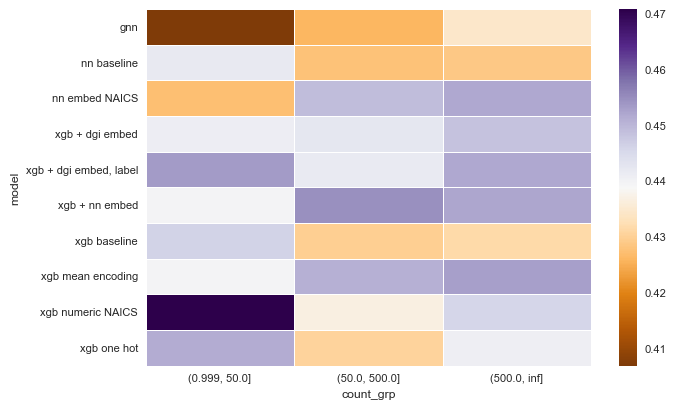

In [484]:
ax = sns.heatmap(plot_df.transpose(), linewidth=0.5, cmap="PuOr")
plt.show()

In [ ]:
TO DO
- Fix GNN?  Make NAICS a node?  With large sampling, 2 hop?
- Pretty up these plots - order model categories, etc.  Font sizes,etc.  Include more models
- Preliminary embedding plots